In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import uproot
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib
from matplotlib import pyplot as plt
import pickle

from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from keras.utils import np_utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [2]:
# Open signal and background datasets

first_bkg   = '../analysis/objects_TT_TuneCUETP8M2T4_13TeV-powheg-pythia8.root'
input_bkg   = [ '../analysis/objects_QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT300to500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT200to300_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root',
                '../analysis/objects_QCD_HT100to200_TuneCUETP8M1_13TeV-madgraphMLM-pythia8.root']
input_sig  = '../analysis/objects_gg_HH_bbbb_SM.root'
datsp_bkg  = '../background/data_3btag_with_weights_AR.root'
treename = 'bbbbTree'

## convert to dataframes
vars_training = [ 'H1_b1_pt', 'H1_b2_pt', 'H2_b1_pt', 'H2_b2_pt',
#                  'H1_b1_m', 'H1_b2_m', 'H2_b1_m', 'H2_b2_m', 
                  'H1_b1_eta', 'H1_b2_eta', 'H2_b1_eta', 'H2_b2_eta', 
                  'H1_eta', 'H1_pt', 'H2_eta', 'H2_pt', 
                  'HH_eta', 'HH_pt','HH_m', 'H1H2_deltaEta', 'H1_costhetaCM', 'H1H2_deltaPhi']

# extra variables needed for preselections
all_vars = vars_training + ['H1_m', 'H2_m', 'n_btag']
all_vars = list(set(all_vars))

bkg_source = 'data'
print "... opening input files"

if bkg_source == 'MC':
    arrs_bkg = [None]*(len(input_bkg)+1)

    print "Opening file: ", input_sig
    arrs_sig  = uproot.open(input_sig)[treename]

    print "Opening file: ", first_bkg
    arrs_bkg[0]  = uproot.open(first_bkg)[treename]

    data_bkg = arrs_bkg[0].pandas.df(all_vars)
    data_sig = arrs_sig.pandas.df(all_vars)

    j=1
    for i in (input_bkg):
        print "Opening file: ", i
        arrs_bkg[j] = uproot.open(i)[treename]
        temp_bkg = arrs_bkg[j].pandas.df(all_vars)
        data_bkg = data_bkg.append(temp_bkg)
        j=j+1
else:
    
    print "Opening file: ", input_sig
    arrs_sig  = uproot.open(input_sig)[treename]
    
    print "Opening file: ", datsp_bkg
    arrs_bkg  = uproot.open(datsp_bkg)[treename]
    
    data_bkg = arrs_bkg.pandas.df(all_vars+['bkg_model_w'])
    data_sig = arrs_sig.pandas.df(all_vars)

... opening input files
Opening file:  ../analysis/objects_gg_HH_bbbb_SM.root
Opening file:  ../background/data_3btag_with_weights_AR.root


In [3]:
print "... preselecting data"

## apply a selection on the datasets
data_bkg = data_bkg[data_bkg['n_btag'] == 3]
data_sig = data_sig[data_sig['n_btag'] >= 4]

# restrict training to the signal region
data_bkg['chi'] = np.sqrt( (data_bkg['H1_m']-120)*(data_bkg['H1_m']-120)+(data_bkg['H2_m']-110)*(data_bkg['H2_m']-110))
data_sig['chi'] = np.sqrt( (data_sig['H1_m']-120)*(data_sig['H1_m']-120)+(data_sig['H2_m']-110)*(data_sig['H2_m']-110))

data_bkg = data_bkg[data_bkg['chi'] < 30]
data_sig = data_sig[data_sig['chi'] < 30]

data_bkg = data_bkg.drop(columns=['n_btag','H1_m','H2_m','chi'])
data_sig = data_sig.drop(columns=['n_btag','H1_m','H2_m','chi'])

## for the signal, add a fake weight column
if bkg_source == 'data':
    data_bkg['train_w'] = data_bkg['bkg_model_w']
    data_bkg.drop('bkg_model_w', axis=1, inplace=True)
    data_sig['train_w'] = 1
    
# normalise the sum of weights to unity
data_bkg['train_w'] = data_bkg['train_w'].multiply(1./data_bkg['train_w'].sum())
data_sig['train_w'] = data_sig['train_w'].multiply(1./data_sig['train_w'].sum())
    
## label the datasets as bkg (0) and signal (1)
data_bkg['isSignal'] = np.zeros(len(data_bkg))
data_sig['isSignal'] = np.ones(len(data_sig))

... preselecting data


In [4]:
# Divide data into testing and training

if bkg_source == 'MC':
    NDIM = len(vars_training)
else:
    NDIM = len(vars_training)

all_data = pd.concat([data_bkg, data_sig], axis=0, sort=False)
#normalized_data = (all_data-all_data.min())/(all_data.max()-all_data.min())

# preprocessing: standard scalar
scaler = StandardScaler().fit(all_data[vars_training])
all_data[vars_training] = scaler.transform(all_data[vars_training])

all_data_train, all_data_test = train_test_split(all_data, test_size=0.33, random_state=123456)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                  verbose=0, save_best_only=True, 
                                  save_weights_only=False, mode='auto', 
                                  period=1)

In [9]:
#Create Model

inputs = Input(shape=(NDIM,), name = 'input')
x = Dropout(.2, name = 'input_dropout_.2')(inputs)
x = Dense(128, name = 'hidden1')(x)
x = LeakyReLU(.1, name = 'LeakyReLU1_.1')(x)
x = Dense(128, name = 'hidden2')(x)
x = LeakyReLU(.1, name = 'LeakyReLU2_.1')(x)
x = Dropout(.4, name = 'hidden2_dropout_.5')(x)
# x = Dense(128, name = 'hidden3')(x)
# x = LeakyReLU(.1 , name = 'LeakyReLU3_.1')(x)
# x = Dropout(.2, name = 'hidden3_dropout_.2')(x)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(x)

# creae the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18)                0         
_________________________________________________________________
input_dropout_.2 (Dropout)   (None, 18)                0         
_________________________________________________________________
hidden1 (Dense)              (None, 128)               2432      
_________________________________________________________________
LeakyReLU1_.1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 128)               16512     
_________________________________________________________________
LeakyReLU2_.1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
hidden2_dropout_.5 (Dropout) (None, 128)               0         
__________

In [10]:
history = model.fit(all_data_train[vars_training], 
                    all_data_train['isSignal'],
                    epochs=50, 
                    batch_size=1024, 
                    sample_weight = all_data_train['train_w'].values,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint], 
                    validation_split=0.25)

Train on 680826 samples, validate on 226943 samples
Epoch 1/50
680826/680826 [==============================] - 12s 17us/step - loss: 9.4015e-07 - acc: 0.6595 - val_loss: 8.1750e-07 - val_acc: 0.7556
Epoch 2/50
680826/680826 [==============================] - 11s 17us/step - loss: 8.0929e-07 - acc: 0.7665 - val_loss: 7.4469e-07 - val_acc: 0.7645
Epoch 3/50
680826/680826 [==============================] - 12s 18us/step - loss: 7.8033e-07 - acc: 0.7582 - val_loss: 7.2472e-07 - val_acc: 0.7390
Epoch 4/50
680826/680826 [==============================] - 11s 16us/step - loss: 7.6481e-07 - acc: 0.7450 - val_loss: 7.1230e-07 - val_acc: 0.7279
Epoch 5/50
680826/680826 [==============================] - 10s 14us/step - loss: 7.5619e-07 - acc: 0.7359 - val_loss: 7.0083e-07 - val_acc: 0.7288
Epoch 6/50
680826/680826 [==============================] - 9s 14us/step - loss: 7.4908e-07 - acc: 0.7331 - val_loss: 6.9427e-07 - val_acc: 0.7328
Epoch 7/50
680826/680826 [==============================] - 1

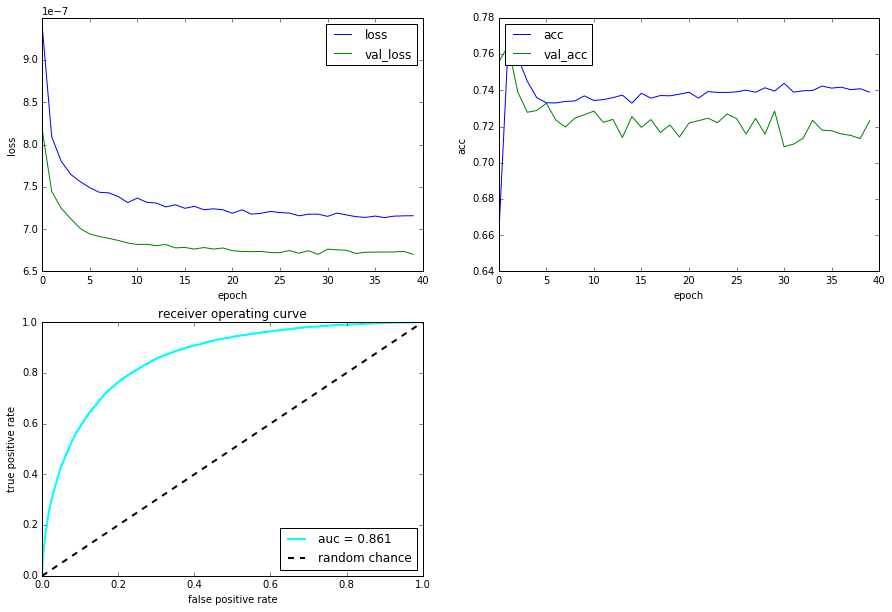

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(all_data_test[vars_training])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_data_test['isSignal'], Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()

... drawing discriminator output


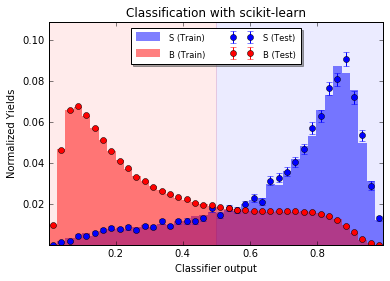

In [16]:
# Plot Classifier Output

def plot_classifier_output():

    print '... drawing discriminator output'
    
    sig_train = all_data_train[all_data_train.isSignal == 1][vars_training]
    bkg_train = all_data_train[all_data_train.isSignal == 0][vars_training]
    
    sig_test  = all_data_test[all_data_test.isSignal == 1][vars_training]
    bkg_test  = all_data_test[all_data_test.isSignal == 0][vars_training]

    ## these are already normalised to unity
    weights_sig_train = all_data_train[all_data_train.isSignal == 1]['train_w']
    weights_bkg_train = all_data_train[all_data_train.isSignal == 0]['train_w']    
    
    weights_sig_test  = all_data_test[all_data_test.isSignal == 1]['train_w']
    weights_bkg_test  = all_data_test[all_data_test.isSignal == 0]['train_w']

    ## but before the splitting, so re-normalise
    weights_sig_train = weights_sig_train.multiply(1./weights_sig_train.sum())
    weights_bkg_train = weights_bkg_train.multiply(1./weights_bkg_train.sum())
    
    weights_sig_test = weights_sig_test.multiply(1./weights_sig_test.sum())
    weights_bkg_test = weights_bkg_test.multiply(1./weights_bkg_test.sum())

    #if n_classses > 2 sig proba is the last one (in the way the code is written) 
    Y_pred_sig_train = model.predict(sig_train)[:,0]
    Y_pred_bkg_train = model.predict(bkg_train)[:,0]
    Y_pred_sig_test  = model.predict(sig_test)[:,0]
    Y_pred_bkg_test  = model.predict(bkg_test)[:,0]

    # This will be the min/max of our plots
    c_max = max(np.max(d) for d in np.concatenate([Y_pred_sig_train,Y_pred_bkg_train,Y_pred_sig_test,Y_pred_bkg_test]))
    c_min = min(np.min(d) for d in np.concatenate([Y_pred_sig_train,Y_pred_bkg_train,Y_pred_sig_test,Y_pred_bkg_test]))

    # Get histograms of the classifiers
    Histo_training_S = np.histogram(Y_pred_sig_train,bins=40,range=(c_min,c_max),weights=weights_sig_train)
    Histo_training_B = np.histogram(Y_pred_bkg_train,bins=40,range=(c_min,c_max),weights=weights_bkg_train)
    Histo_testing_S = np.histogram(Y_pred_sig_test,bins=40,range=(c_min,c_max),weights=weights_sig_test)
    Histo_testing_B = np.histogram(Y_pred_bkg_test,bins=40,range=(c_min,c_max),weights=weights_bkg_test)
    
    # Lets get the min/max of the Histograms
    AllHistos = [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
    h_max     = max([histo[0].max() for histo in AllHistos])*1.2
    h_min     = min([histo[0].min() for histo in AllHistos])
    
    # Get the histogram properties (binning, widths, centers)
    bin_edges = Histo_training_S[1]
    bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
    bin_widths = (bin_edges[1:] - bin_edges[:-1])
    
    # To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
    ErrorBar_testing_S = np.sqrt(Histo_testing_S[0]/Y_pred_sig_test.size)
    ErrorBar_testing_B = np.sqrt(Histo_testing_B[0]/Y_pred_bkg_test.size)
    
    plt.clf() 
    # Draw objects
    ax1 = plt.subplot(111)
    
    # Draw solid histograms for the training data
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
    ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
    
    # # Draw error-bar histograms for the testing data
    ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
    ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
    
    # Make a colorful backdrop to show the clasification regions in red and blue
    ax1.axvspan(0.5, c_max, color='blue',alpha=0.08)
    ax1.axvspan(c_min,0.5, color='red',alpha=0.08)

    # Adjust the axis boundaries (just cosmetic)
    ax1.axis([c_min, c_max, h_min, h_max])

    # Make labels and title
    plt.title("Classification with scikit-learn")
    plt.xlabel("Classifier output")
    plt.ylabel("Normalized Yields")
    
    # Make legend with smalll font
    legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
    for alabel in legend.get_texts():
        alabel.set_fontsize('small')

    # Save the result to png
    plt.savefig("nn_score_output.png")

plot_classifier_output()